Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import recall_score, precision_score, f1_score

from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples


Reading files

In [2]:
# Clase contains which type of tissue is each
X = pd.read_csv('datasets/dataset_tissue.txt', index_col = 0).T
y = pd.read_csv('datasets/clase.txt', index_col = 0)

There is no need of using pipelines in this case, so it is scaled the data as first step

In [14]:
from sklearn.preprocessing import MinMaxScaler
X_sc = MinMaxScaler().fit_transform(X)

In [15]:
X.shape

(189, 22215)

It has to be known the appropiate number of components which are employed to perform PCA algorythm

In [16]:
# declaring and pca instance
pca_all = PCA(n_components = X.shape[0], random_state = 23)

# fitting pipeline
pca_all.fit(X_sc)

PCA(n_components=189, random_state=23)

Plotting cumulative variance ratio

Number of components: 60


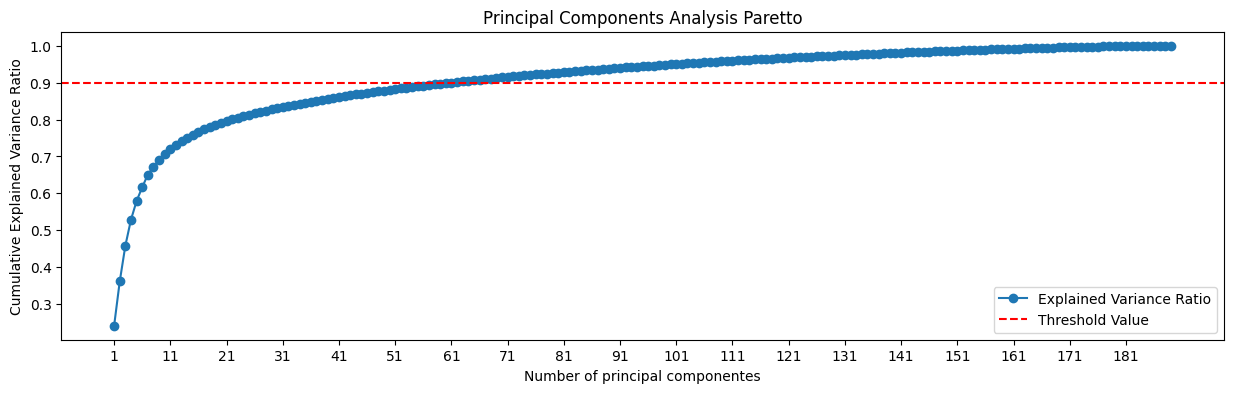

In [17]:
# getting cumulative variance
cum_variance = np.cumsum(pca_all.explained_variance_ratio_)

# choosing threshold
threshold = 0.90

# Calculating the selected number of components by using the chosen threshold
n_pca = len(cum_variance[cum_variance <= threshold])
print(f"Number of components: {n_pca}")

# defining plot
plt.figure(figsize = (15, 4))
plt.plot(cum_variance, '-o', label = 'Explained Variance Ratio')
plt.title('Principal Components Analysis Paretto')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.xlabel('Number of principal componentes')
plt.xticks(range(0, X.shape[0], 10), range(1, X.shape[0] + 1, 10))
plt.axhline(threshold, c = 'red', label = 'Threshold Value', linestyle = '--')
plt.legend()
plt.show()

Then the new X dataset is fitted by using the found n_components

In [18]:
# declaring and pca instance
pca = PCA(n_components = n_pca, random_state = 23)

# fitting model
X_pca = pca.fit_transform(X_sc)

In [19]:
kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(X_pca)

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [39]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score

from sklearn.model_selection import KFold

def optimize_k_means_Elbow(data, max_k):
   
    means = []
    inertias = []
    
    for k in range(1, max_k):
        
        kmeans = KMeans(n_clusters = k, random_state = 0, n_init='auto')
        kmeans.fit(X_pca)

        means.append(k)
        inertias.append(kmeans.inertia_)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot( means, inertias, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()

def optimize_k_means_silhouette(data, max_k):
    silhouette_scores = []
    
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), silhouette_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

def gap_statistics(data, max_k, n_refs=5):
    gaps = []
    std_refs = []
    
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(data)
        inertia = kmeans.inertia_
        
        gap = []
        for _ in range(n_refs):
            random_data = np.random.random_sample(size=data.shape)
            random_kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
            random_labels = random_kmeans.fit_predict(random_data)
            random_inertia = random_kmeans.inertia_
            gap.append(np.log(random_inertia) - np.log(inertia))
        
        gaps.append(np.mean(gap))
        std_refs.append(np.std(gap))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(range(1, max_k), gaps, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Gap Statistics')
    plt.grid(True)
    plt.show()


def optimize_k_means_calinski_harabasz(data, max_k):
    calinski_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        labels = kmeans.fit_predict(data)
        calinski_score = calinski_harabasz_score(data, labels)
        calinski_scores.append(calinski_score)

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), calinski_scores, 'o-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.grid(True)
    plt.show()

def cross_validate_k_means(data, max_k, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    inercias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
        fold_inercias = []
        
        for train_idx, _ in kf.split(data):
            kmeans.fit(data[train_idx])
            fold_inercias.append(kmeans.inertia_)
        
        inercias.append(np.mean(fold_inercias))
    
    best_k = np.argmin(inercias) + 1
    return best_k

def plot_silhouette_with_clusters(data, k):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(data)
    silhouette_avg = silhouette_samples(data, labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Gráfico de silueta
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(data) + (k + 1) * 10])
    
    y_lower = 10
    
    for i in range(k):
        cluster_silhouette_vals = silhouette_avg[labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title('Silhouette Plot')
    ax1.set_xlabel('Silhouette Score')
    ax1.set_ylabel('Cluster')
    
    # Visualización de los clusters
    colors = plt.cm.viridis(labels.astype(float) / k)
    ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    
    ax2.set_title('Cluster Visualization')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    
    plt.show()

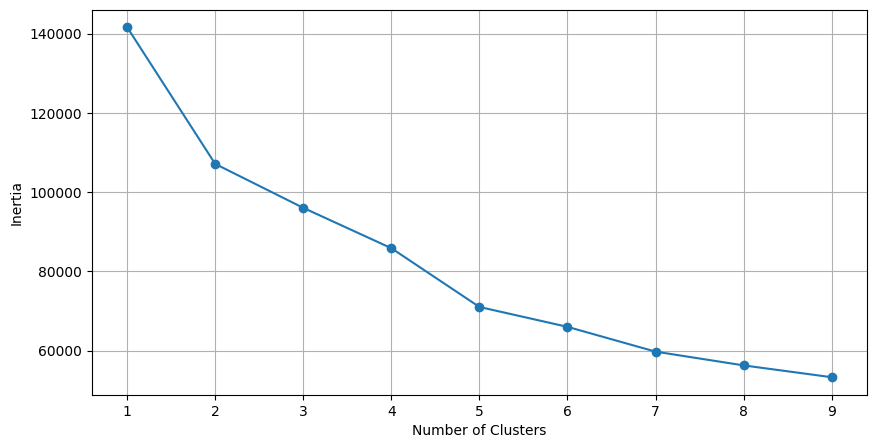

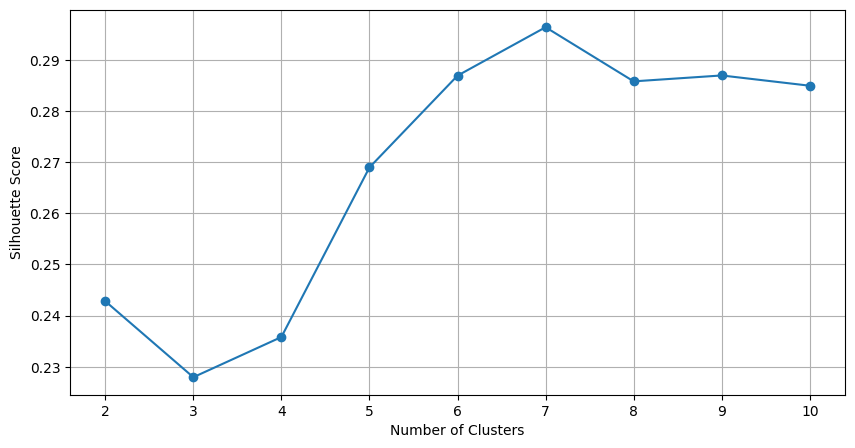

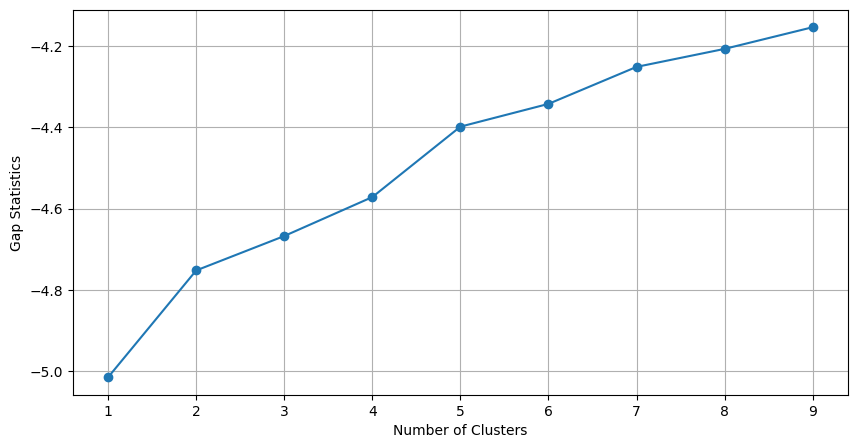

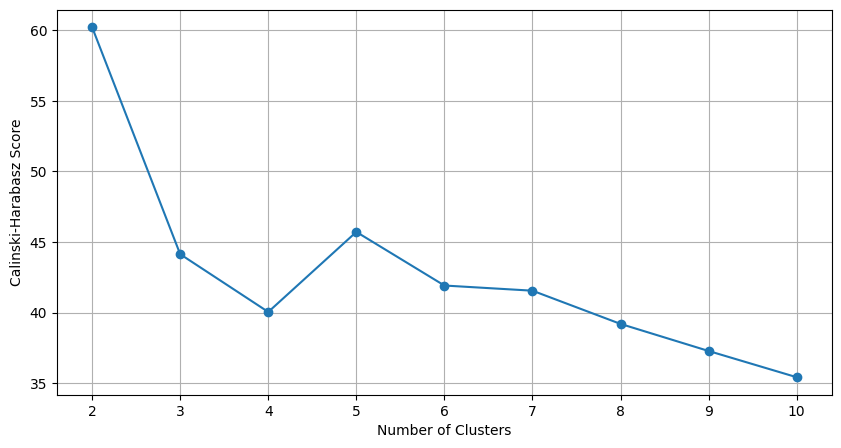

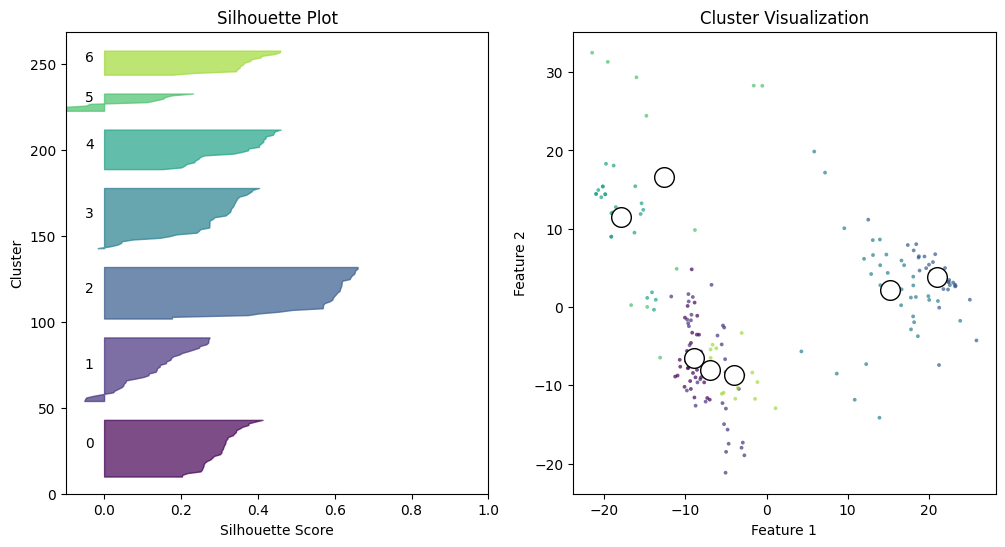

In [42]:
optimize_k_means_Elbow (X_pca, 10)
optimize_k_means_silhouette(X_pca, 10)
gap_statistics(X_pca, 10)
optimize_k_means_calinski_harabasz(X_pca, 10)
cross_validate_k_means(X_pca, 10)

plot_silhouette_with_clusters(X_pca,7)


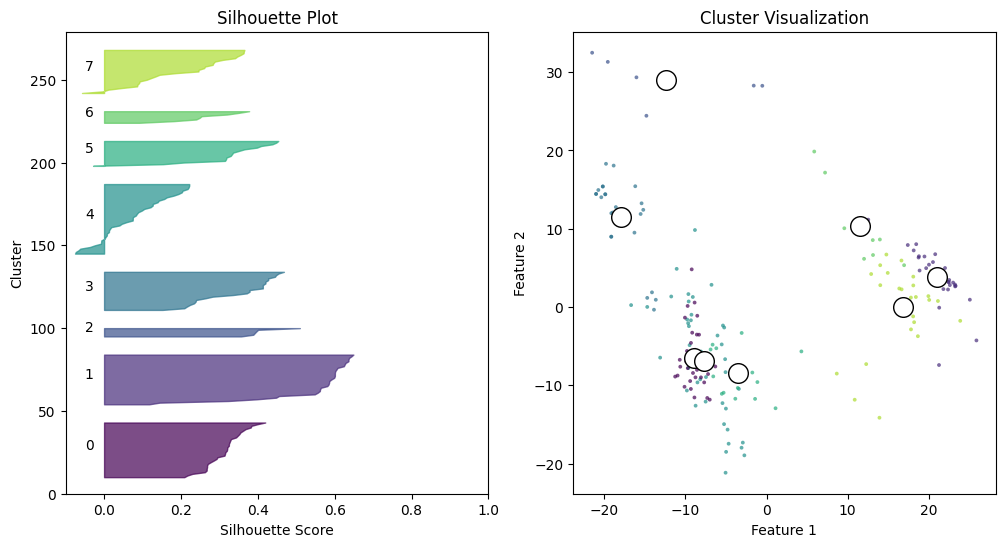

In [44]:

plot_silhouette_with_clusters(X_pca,8)

Applying K Means Clustering

In [46]:
kmeans = KMeans(n_clusters = 7, random_state = 0, n_init='auto')
kmeans.fit(X_pca)


KMeans(n_clusters=7, n_init='auto', random_state=0)

In [47]:
kmeans_labels = kmeans.labels_
kmeans_labels

array([1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 5, 4, 4, 4, 1, 1, 1, 4, 4, 4,
       1, 1, 2, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3,
       3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 5, 5, 5])

In order to visualize how clusters were corresponded, another pca fit is done but this time only with 2 components to have x-y axis

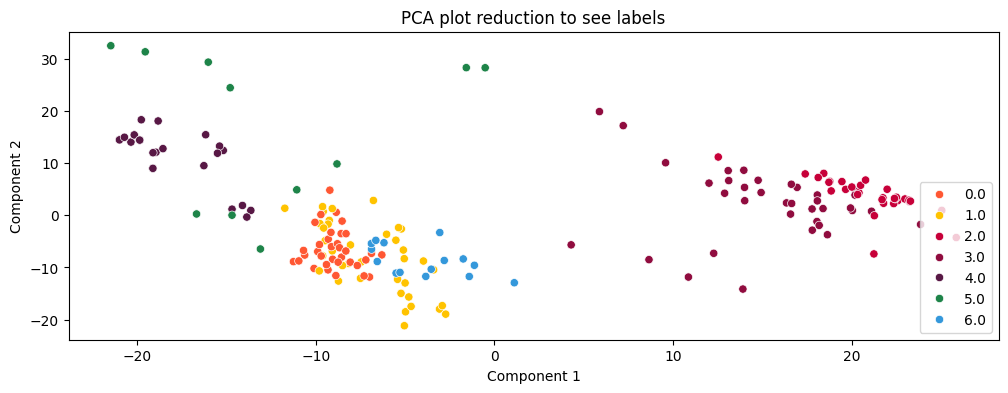

In [50]:
# declaring pca instance to use to plot
pca_plot = PCA(n_components = 2, random_state = 23)
n_components= len(np.unique(kmeans_labels))

# Creating the X_plot data set
X_plot = pca_plot.fit_transform(X_sc)
X_plot_gauss= np.c_[X_plot, kmeans_labels]

# ploting with sns
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]

plt.figure(figsize = (12, 4))          
sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = X_plot_gauss[:, 2], palette = colors[:n_components])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('PCA plot reduction to see labels')
plt.legend(loc = 'lower right')
plt.show()

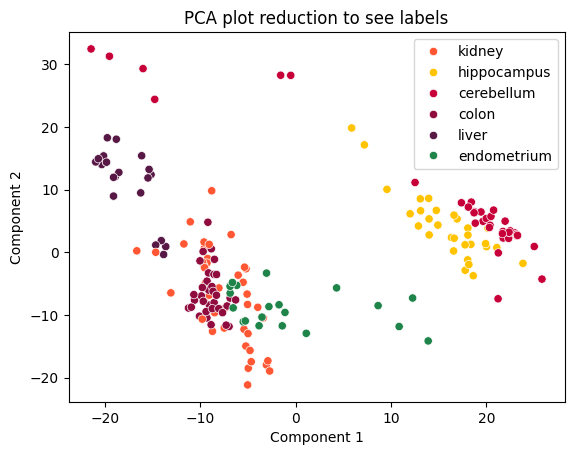

In [88]:
# Creating a dataframe with gaussian clusters and actual labels
base_information = {'kmeans_labels': kmeans_labels,
                    'label_name': y.to_numpy().ravel()}

data_clusters = pd.DataFrame(base_information)


# querying dataframe to verify most frequent label name per gaussian label
kmenas_dict = data_clusters.groupby('kmeans_labels').agg({'label_name': lambda x: x.mode().iloc[0]}).to_dict()['label_name']
data_clusters['predicted_label_name'] = data_clusters['kmeans_labels'].map(kmenas_dict) # predictions
n_unique_predicted = len(np.unique(data_clusters['predicted_label_name']))

# ploting with sns
colors = ["#FF5733", "#FFC300", "#C70039", "#900C3F", "#581845", "#1E8449", "#3498DB",
            "#FF33FF", "#33FFCC", "#FF6666", "#99CC99", "#3399FF", "#FF9933", "#CC33FF", "#66CCCC"]
            
sns.scatterplot(x = X_plot_gauss[:, 0], y = X_plot_gauss[:, 1], hue = data_clusters['predicted_label_name'], palette = colors[:n_unique_predicted])
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title('PCA plot reduction to see labels')
plt.legend(loc = 'upper right')
plt.show()


In [89]:
# getting actual values and predictions
y_actual = data_clusters.label_name
y_pred = data_clusters.predicted_label_name

# getting scores
recall_kmeans = recall_score(y_actual, y_pred, average = 'macro', zero_division = 0)
precision_kmeans = precision_score(y_actual, y_pred, average = 'macro', zero_division = 0)
f1_kmeans = f1_score(y_actual, y_pred, average = 'macro', zero_division = 0)

# Showing metrics
print(f"Recall score: {recall_kmeans:.4f}")
print(f"Precision score: {precision_kmeans:.4f}")
print(f"F1 score: {f1_kmeans:.4f}")

Recall score: 0.8200
Precision score: 0.7861
F1 score: 0.7999
